郭昊轩 西安交通大学 能源与动力工程学院/核科学与技术学院

skyair@stu.xjtu.edu.cn

# 为什么要做并行

这是计算机的硬件发展决定的。

因为单核性能已经很难再提升了，现代处理器大多数都是多核处理器，要采用并行才能发挥出多核处理器的全部能力。

# 在一切开始之前

In [1]:
using BenchmarkTools

## 确保时间复杂度已经优化到极致

比如计算刚学习编程时接触过的斐波那契数列就有非常多的计算方法。

比如其中一种就是用它的定义进行递归运算，也就是

$$ \mathrm{fibnacci}(n) = 
\begin{cases}
1 ,& n \le 2 \\
\mathrm{fibnacci}(n-1) + \mathrm{fibnacci}(n-2) ,& \text{其他}
\end{cases}
$$

In [2]:
fibnacci_naive(x) = x > 2 ? fibnacci_naive(x - 1) + fibnacci_naive(x - 2) : 1

fibnacci_naive (generic function with 1 method)

这固然是正确的。然而在效率上却是非常低下的。

它的时间复杂度很容易分析。函数调用的次数刚好就是斐波那契数列第n项的值，因此是$ \mathcal{O}(\mathrm{fibnacci}(n)) = \mathcal{O}\left( \frac{1}{\sqrt{5}} \left[ \left( \frac{1+\sqrt{5}}{2} \right)^n - \left( \frac{1-\sqrt{5}}{2} \right)^n \right] \right) \approx \mathcal{O}(2^n)$。

指数级别时间复杂度的算法往往并不是一个优秀的算法。

对于斐波那契数列的递推公式可以写成矩阵形式，使得

$$
\begin{bmatrix}
1 & 1 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
\mathrm{fibnacci}(n) \\
\mathrm{fibnacci}(n+1)
\end{bmatrix}
=
\begin{bmatrix}
\mathrm{fibnacci}(n+1) \\
\mathrm{fibnacci}(n+2)
\end{bmatrix}
$$

所以，斐波那契数列的第n项就可以写成

$$
\mathrm{fibnacci}(n)=
\left(
\begin{bmatrix}
1 & 1 \\
1 & 0
\end{bmatrix}^{n-2}
\begin{bmatrix}
\mathrm{fibnacci}(1) \\
\mathrm{fibnacci}(2)
\end{bmatrix}
\right)_{1,1}
=
\left(
\begin{bmatrix}
1 & 1 \\
1 & 0
\end{bmatrix}^{n-1}
\right)_{1,1}
$$

矩阵乘法可以用快速幂来完成，时间复杂度是$\mathcal{O}(\log_2 n)$，因此，这个算法总的时间复杂度只有$\mathcal{O}(\log_2 n)$。

In [4]:
fibnacci(n) = ([1 1; 1 0]^(n - 1))[1, 1]

fibnacci (generic function with 1 method)

比较这两者的运行速度，可以发现差距巨大。

In [5]:
@btime fibnacci_naive(42)

  915.091 ms (0 allocations: 0 bytes)


267914296

In [6]:
@btime fibnacci(42)

  377.746 ns (9 allocations: 944 bytes)


267914296

采用不同算法造成的事件差距往往不止<span style="color:red;">亿点点</span>。因此，算法带来的时间差距才是主要矛盾，在琢磨并行加速这些有的没的之前一定要确保算法的时间复杂度已经优化到了极致。

接下来举一个简单的例子，并通过这个例子来说明并行加速和GPU加速具体来说是怎么进行操作的。这个例子非常简单，就是对一张图片进行高斯模糊。

In [7]:
using FileIO, ImageShow, LinearAlgebra, Colors

首先，读入一张图片

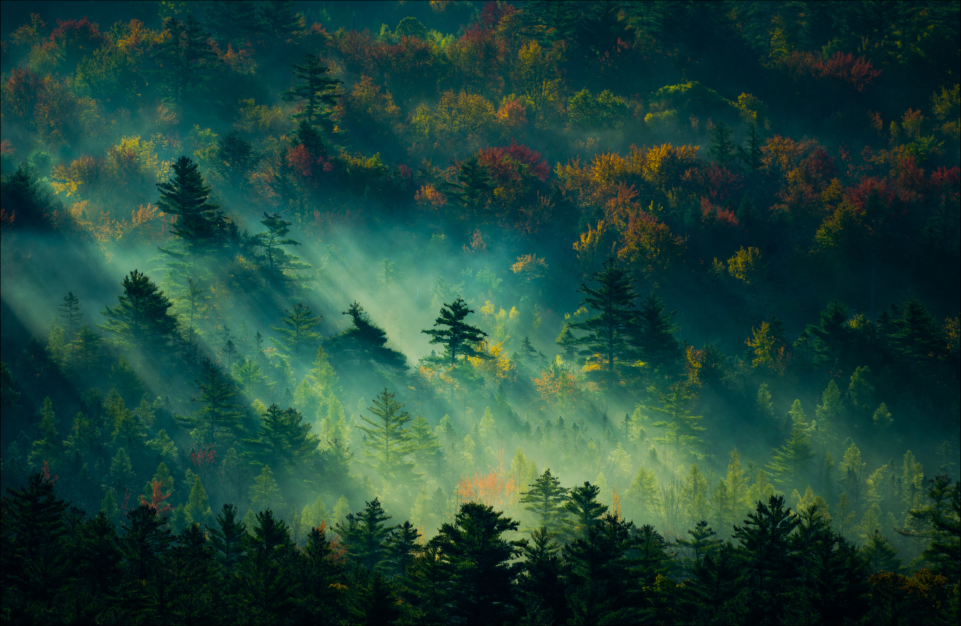

In [8]:
img = load("imag.jpg") |> Matrix{ColorTypes.RGB{Float32}}

高斯模糊就是对图像中的像素做高斯加权平均，一维和二维的高斯函数标准形式定义为

$$ f(x) = \frac{1}{\sqrt{2 \pi}} \mathrm{exp}(-x^2/2) $$
$$ f(x,y) = \frac{1}{\sqrt{2 \pi}} \mathrm{exp}\left(-(x^2+y^2)/2\right) $$

In [9]:
gaussian(x) = 1 / sqrt(2π) * exp(-x^2 / 2)
gaussian(x, y) = 1 / sqrt(2π) * exp(-(x^2 + y^2) / 2)

gaussian (generic function with 2 methods)

加权平均操作可以写成和高斯矩阵的卷积核（掩码）进行卷积，首先生成这个卷积核。

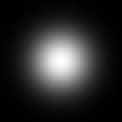

In [10]:
function gaussian_mask(px::Int)
    result = [gaussian((i - px - 1) * 3 / px, (j - px - 1) * 3 / px) for i in 1:(2px + 1), j in 1:(2px + 1)]
    result /= sum(result)
end
mask = gaussian_mask(30)
mask ./ maximum(mask) .|> ColorTypes.Gray{Float32}

接着写一个朴素的卷积函数

In [12]:
function ⊗(matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
    matrix_size = size(matrix)
    mask_size = size(mask)
    px = size(mask) .÷ 2
    result = zeros(T, matrix_size .- 2 .* px)
    for i in 1:size(result)[1], j in 1:size(result)[2]
        for idx in 1:mask_size[1], jdx in 1:mask_size[2]
            result[i, j] += matrix[i + idx - 1, j + jdx - 1] * mask[idx, jdx]
        end
    end
    return result
end

⊗ (generic function with 1 method)

太慢了，需要想一些加速的方法。

二维高斯函数可以看成两次一维高斯函数，因此高斯模糊也可以正交地拆分成两次一维的高斯模糊。因此，获得可以通过一维卷积核来两次卷积。

In [11]:
function gaussian_mask_1d(px::Int)
    result = [gaussian((i - px - 1) * 3 / px, (j - px - 1) * 3 / px) for i in 1:1, j in 1:(2px + 1)]
    result /= sum(result)
end
mask = gaussian_mask_1d(30)
mask ./ maximum(mask) .|> ColorTypes.Gray{Float32}

  7.206 s (4 allocations: 213.78 MiB)


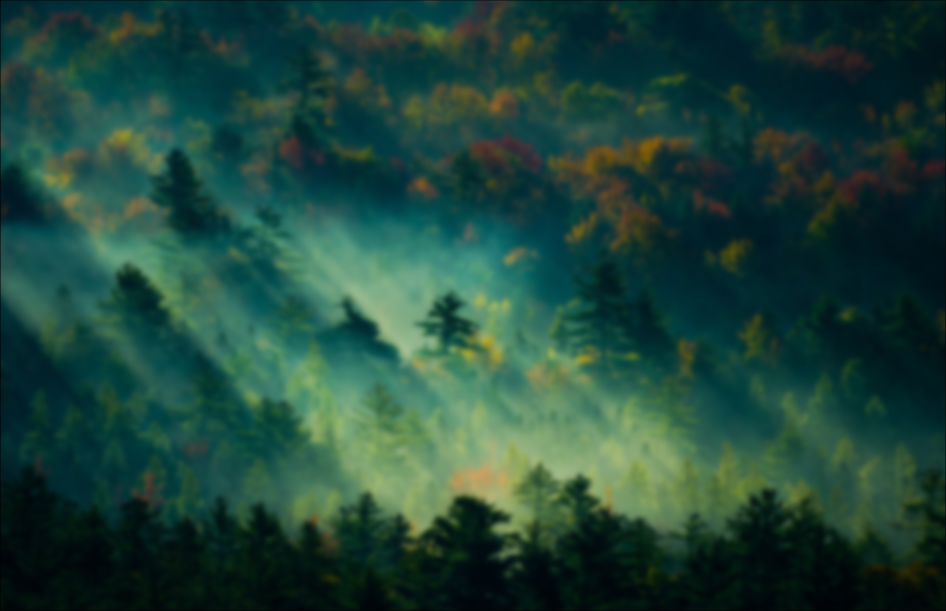

In [13]:
@btime $img ⊗ $mask ⊗ $(mask')

继续优化的办法：

### 用3次均值模糊替代高斯模糊。

根据中心极限定理可以猜测，多次均值模糊和一次高斯模糊应该是等效的。

Peter Kovesi 在Paper中提出了,Box blur在多次iteration之后会逼近Gaussian分布。于是我们可以重复多次Box blur来替代高斯分布的权重计算。
同时Peter Kovesi还提出，高斯模糊的标准差和BoxBlur的box半径大小存在如下的关系。
$$ \omega = \sqrt{\frac{12\sigma^2}{n} + 1} $$

均值滤波不需要计算权重的乘法，还可以利用累加器进一步优化时间复杂度。

### 用查表代替乘法
对于小掩码（比如$3\times3$）来说，掩码只有3种，颜色只有256种，直接存下所有可能然后查表比乘法快很多。

## 性能标注

采用性能标注对编译器采用某些承诺可以微小的提升性能。

### `@inbounds`

采用`@inbounds`可以让julia放弃对数据下标访问进行越界检查，采用类似于C/C++的地址偏移访问。虽然这让julia做的事更少了，但让写下这段代码的人工作变多了。因为写下这段代码的人需要非常清楚的知道，这里的下标访问不会发生越界。对C/C++来说越界访问会发生段错误，julia照样会。

  8.670 s (4 allocations: 213.78 MiB)


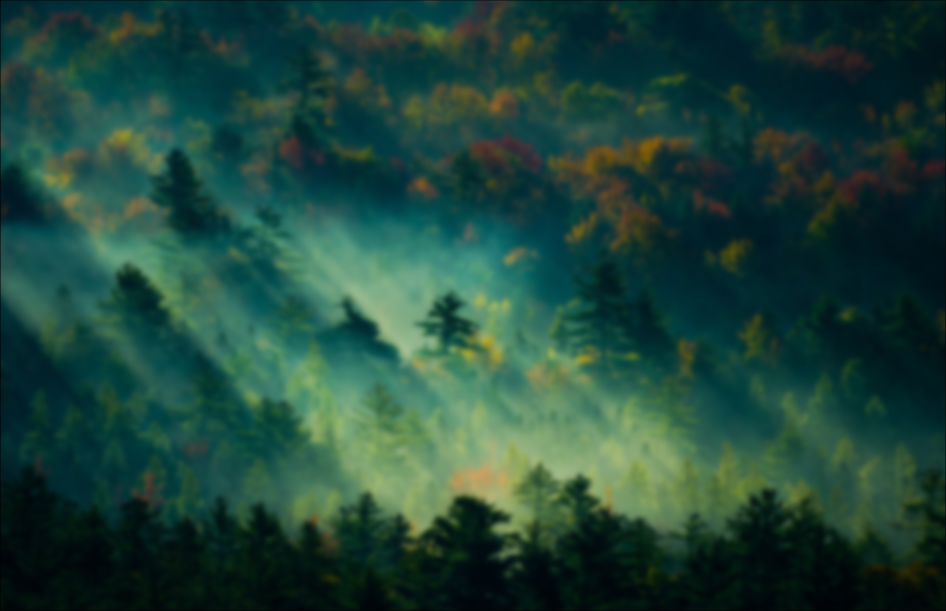

In [15]:
function ⊗(matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
    matrix_size = size(matrix)
    mask_size = size(mask)
    px = size(mask) .÷ 2
    result = zeros(T, matrix_size .- 2 .* px)
    @inbounds for i in 1:size(result)[1], j in 1:size(result)[2]
        for idx in 1:mask_size[1], jdx in 1:mask_size[2]
            result[i, j] += matrix[i + idx - 1, j + jdx - 1] * mask[idx, jdx]
        end
    end
    return result
end
@btime $img ⊗ $mask ⊗ $(mask')

### `@fastmath`

计算机中的浮点数应该满足IEEE标准进行表示，但是这并不是最快的做法。使用`@fastmath`来暂时忽略IEEE的规定，进行实数上正确，但可能有更大浮点误差的快速数学运算。显然，对于`Inf`、`-Inf`和`NaN`这会出错，因为这三个特殊的浮点数非常依赖IEEE表示。写下`@fastmath`时，应该确保不会出现依赖于IEEE表示的数字。

  7.143 s (4 allocations: 213.78 MiB)


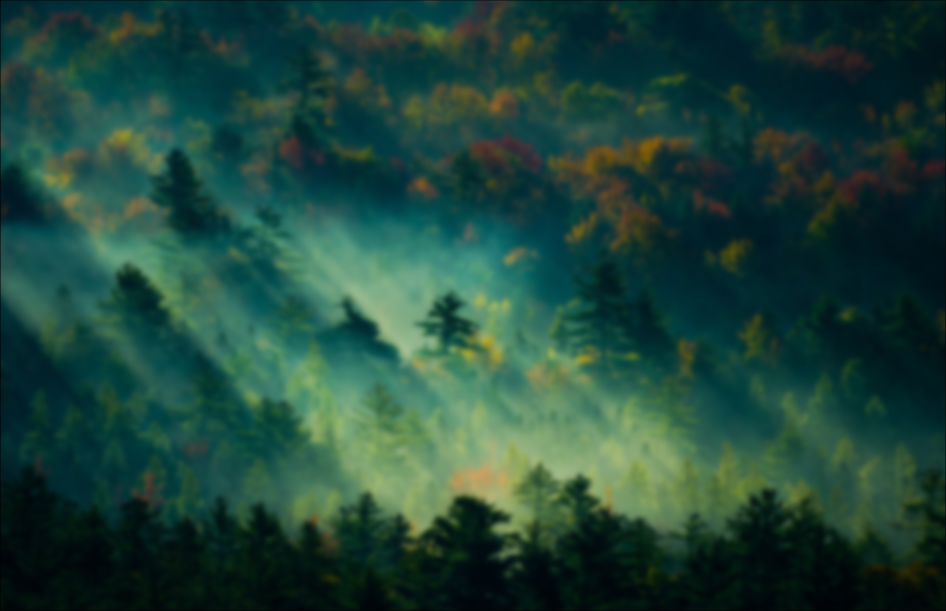

In [16]:
@inbounds @fastmath function ⊗(matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
    matrix_size = size(matrix)
    mask_size = size(mask)
    px = size(mask) .÷ 2
    result = zeros(T, matrix_size .- 2 .* px)
    for i in 1:size(result)[1], j in 1:size(result)[2]
        for idx in 1:mask_size[1], jdx in 1:mask_size[2]
            result[i, j] += matrix[i + idx - 1, j + jdx - 1] * mask[idx, jdx]
        end
    end
    return result
end
@btime $img ⊗ $mask ⊗ $(mask')

### `@simd`

现代CPU往往拥有向量指令，即Single Instruction, Multiple Data（单指令多数据），这包括SSE、AVX之类的指令集。如果能利用好这些指令集，就能并行地处理数据，自然可以更快。然而用到并行，就得先保证是采用的算法是可并行的。对于`@simd`来说，就是要保证被优化的`for`顺序是可以重排的。

  6.641 s (4 allocations: 213.78 MiB)


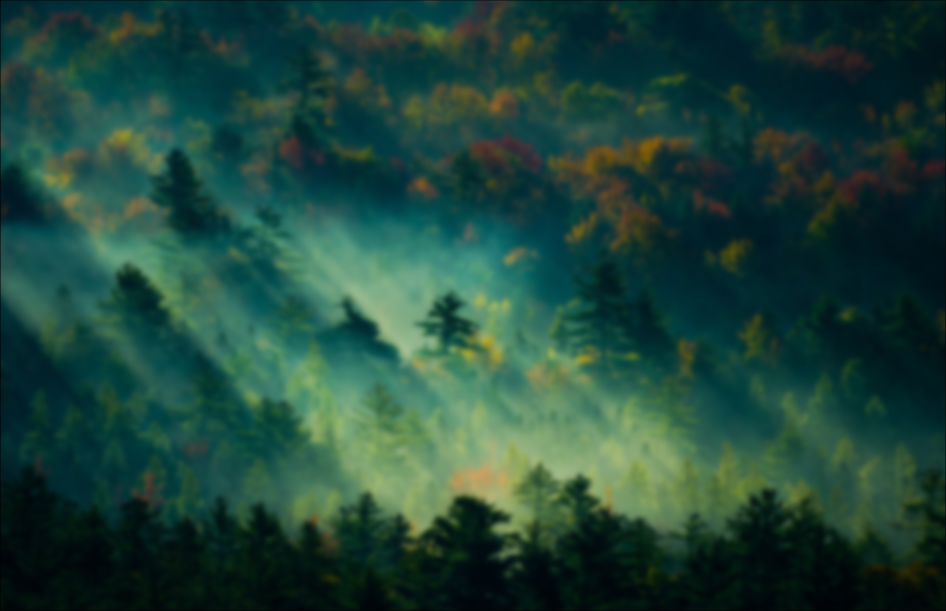

In [17]:
@inbounds @fastmath function ⊗(matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
    matrix_size = size(matrix)
    mask_size = size(mask)
    px = size(mask) .÷ 2
    result = zeros(T, matrix_size .- 2 .* px)
    @simd for i in 1:size(result)[1]
        @simd for j in 1:size(result)[2]
            @simd for idx in 1:mask_size[1]
                @simd for jdx in 1:mask_size[2]
                    result[i, j] += matrix[i + idx - 1, j + jdx - 1] * mask[idx, jdx]
                end
            end
        end
    end
    return result
end
@btime $img ⊗ $mask ⊗ $(mask')

性能标注并不能真的显著提升性能。因为julia的编译器足够聪明，就算用户不去进行标注，它也能自己猜出这里可以进行优化。因此，性能标注在大多数时候都是不必要的。

# 异步

有些时候，CPU并没有真的在算，而是在等。毕竟CPU是整个计算机中最快的部分，等别的部分是常事。那么等的过程中是可以稍微干点别的的，这就是异步。

用`@async`标注需要异步运算的代码，这部分代码立即返回并不会阻塞后面的运行。

In [19]:
@async begin
    for i in 1:10
        sleep(1)
        print("$i ")
    end
end

Task (runnable) @0x00007fd5f844b490

1 2 3 4 5 6 7 8 9 10 

即使在后台提交多个任务，只要CPU没有在干活，就可以同时进行。

In [21]:
for i in 1:10
    @async begin
        sleep(3)
        print("$i ")
    end
end

1 2 3 4 5 6 7 8 9 10 

用`@sync`可以限制异步的范围。必须所有异步任务全都完成在能结束`@sync`指示的范围。

In [22]:
@btime begin
    @sync for i in 1:10
        @async sleep(1)
    end
end

  1.001 s (116 allocations: 6.70 KiB)


单位时间内CPU能做的事情是有限的，对于计算密集型的任务异步<span style="color:red;">并不能</span>提升性能。

In [23]:
@btime rand(512, 512) * rand(512, 512);
@btime @sync begin
    for i in 1:10
        @async rand(512, 512) * rand(512, 512)
    end
end;

  1.856 ms (6 allocations: 6.00 MiB)
  19.813 ms (114 allocations: 60.01 MiB)


# 多线程并行

线程是最小的调度单元。现代CPU往往有多个核心，甚至还有超线程技术能同时运行更多的线程。在多核CPU刚出现的时候，「一核有难，七核围观」的惨剧没少出现。将多个CPU核心都用起来就可以显著提升运算速度。

`Threads.nthreads()`可以查看可以并行使用的线程个数，这个个数是通过`JULIA_NUM_THREADS`环境变量设置的。

In [24]:
@show Threads.nthreads()
versioninfo()

Threads.nthreads() = 48
Julia Version 1.6.4
Commit 35f0c911f4 (2021-11-19 03:54 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8175M CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake-avx512)
Environment:
  JULIA_NUM_THREADS = 48


超线程道理能不能加速？这个跟具体的任务有关。增加线程榨干CPU性能还是增加上下文切换开销这二者处于一个艰难的平衡，但是个人建议不知道结果的时候始终使用真正的CPU核心数来进行运算。

`Threads.threadid()`可以查看当前正在运行的是哪个线程。对于和用户交互的线程，其编号始终为1。

In [25]:
Threads.threadid()

1

将异步标注`@async`替换成`Threads.@spawn`即可将这个任务分配到其他CPU核心上。

In [28]:
Threads.@spawn @show Threads.threadid()

Task (runnable) @0x00007fd60ccc0550

Threads.threadid() = 2


因为参与运算的CPU资源变多了，这真的可以提升性能。

In [29]:
@time rand(2048, 2048) * rand(2048, 2048);
@time @sync begin
    for i in 1:10
        Threads.@spawn rand(2048, 2048) * rand(2048, 2048)
    end
end;

  0.048591 seconds (6 allocations: 96.000 MiB)
  0.434551 seconds (12.10 k allocations: 960.930 MiB, 4.37% compilation time)


但是我们一般并不会用这么原理性的做法，只是简单的在`for`前面加一个`Threads.@threads`，剩下的交给julia编译器就好了。开并行就是如此简单。

In [30]:
@time rand(2048, 2048) * rand(2048, 2048);
@time Threads.@threads for i in 1:10
    rand(2048, 2048) * rand(2048, 2048)
end


  0.058355 seconds (6 allocations: 96.000 MiB)
  0.509000 seconds (57.20 k allocations: 963.606 MiB, 4.33% compilation time)


所以在我们的卷积函数前面for前面愉快的加上`Threads.@threads`吧！

  366.318 ms (490 allocations: 213.83 MiB)


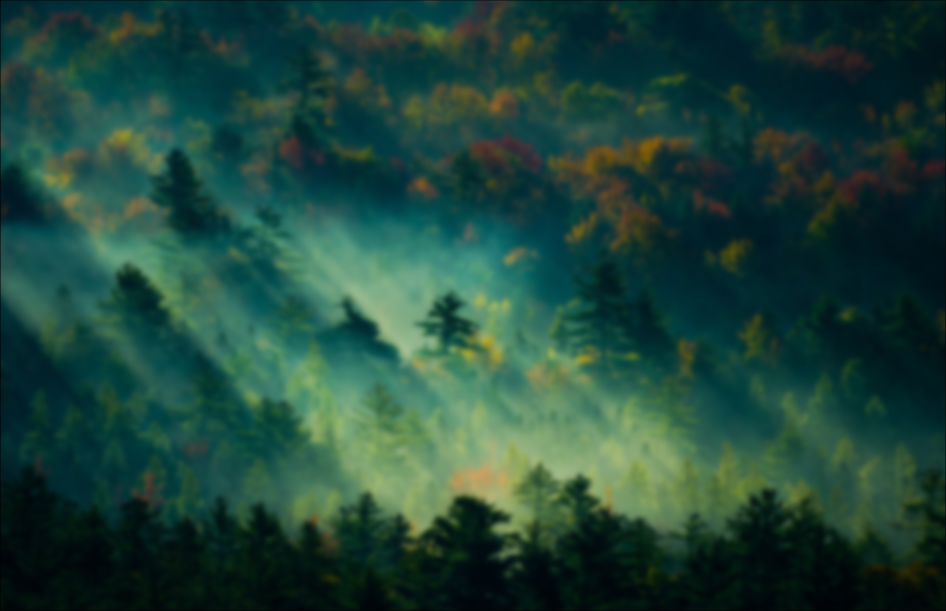

In [64]:
function ⊗(matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
    matrix_size = size(matrix)
    mask_size = size(mask)
    px = size(mask) .÷ 2
    result = zeros(T, matrix_size .- 2 .* px)
    Threads.@threads for i in 1:size(result)[1]
        for j in 1:size(result)[2]
            for idx in 1:mask_size[1], jdx in 1:mask_size[2]
                result[i, j] += matrix[i + idx - 1, j + jdx - 1] * mask[idx, jdx]
            end
        end
    end
    return result
end
@btime $img ⊗ $mask ⊗ $(mask')

这就成功做到了极大的性能提升。

不过或许会好奇为什么我没有在后面的两个for前面也加上`Threads.@threads`。这是为了避免数据竞争。

## 数据竞争
多线程同时读写同一个数据会出问题。

比如一个非常简单的求和[1]。

[1] 陈久宁 [Julia 语言及其应用](https://github.com/johnnychen94/Julia_and_its_applications)

In [32]:
sum(x->x^2, 1:10_000)

333383335000

而开了多线程之后，运行结果就变得不对了。

In [33]:
let result = 0
    Threads.@threads for x in 1:10_000
        result += x^2
    end
    result
end

332333399605

这是因为`+=`其实分三步：
1. 从内存中读到寄存器
2. 运算
3. 从寄存器写回内存

但是如果多线程的时候，则会出现步骤1和步骤3之间另一个线程读走了内存中的值，而在前一个线程写入后覆盖。这相当于前一个线程的工作没有做。

总的来说，这是由于并行带来的指令的乱序执行。为了避免这个问题主要有三种做法。

### 避免同时读写

像我前面那样非常~~鸡贼~~巧妙地不加`Threads.@threads`来让每个变量只可能被一个线程写入。这样就直接避免了数据竞争问题。

### 加锁

但是有些时候是没办法避免的，我们不得不直面这个问题。这个时候只要给可能发生数据竞争的地方加上锁就行了。

julia中的锁有自旋锁（SpinLock）和重入锁（ReentrantLock）两种。在不清楚选哪个的时候直接选重入锁就对了。

In [34]:
let result = 0
    l = ReentrantLock()
    Threads.@threads for x in 1:10_000
        lock(l)
        result += x^2
        unlock(l)
    end
    result
end

333383335000

或者用do语法还可以写的更简单一点，释放锁都是自动的。

In [35]:
let result = 0
    l = ReentrantLock()
    Threads.@threads for x in 1:10_000
        lock(l) do
            result += x^2
        end
    end
    result
end

333383335000

### 原子操作

原子操作是另一种思路。出现竞争是因为`+=`分成三步才能完成，那么只要让它变成不能拆分的一步完成，不就没有竞争问题了吗？

通过`Threads.Atomic{T}`标记一个变量是原子的，那么它的运算都是只有一步。

In [37]:
let result = Threads.Atomic{Int}(0)
    Threads.@threads for x in 1:10_000
        result[] += x^2
    end
    result[]
end

333383335000

# 进程间并行

多线程看起来很美好，但是仍然有它不能发挥作用的时候。比如说随着一台机器上面的CPU增加，访问其他CPU所属的内存时就会变慢。当一台计算机有多个NUMA节点的时候问题更加严重，此时采用多线程的效率就会变低。

线程必须依附于进程，而进程是不能跨节点的。换句话说，采用多线程的方法不能让多台计算机同时处理同一个任务。

想要解决这个问题，则需要进程间并行。

我看到这次的报告中田俊将会专门讲解进程间并行。所以这部分我就不说了，留给他来讲。

# GPU异构运算

GPU是一种大型协处理器，拥有成千上万个运算单元。这种强劲的洪荒之力可以极大的对计算进行加速，但架构间的区别也给驾驭它带来了很大的困难。

In [38]:
using CUDA

一般来说，~~把大象装进冰箱~~GPU加速运算分为三步：
1. 将数据从内存通过总线传递到显存
2. 计算
3. 将数据从显存通过总线传递回内存

将数据传递到显存可以通过将数据转换成`CuArray`类型来完成。

In [40]:
cpu_ram = rand(512, 512)
gpu_ram = CuArray(cpu_ram);

注意，显存上的数据尽量不要输出到屏幕。因为输出到屏幕是标量操作，非常极其特别尤其慢。

当然，也可以直接分配显存。

In [41]:
CuArray{Int}(undef,1024);

In [42]:
CUDA.zeros(1024);

传递回内存只要再转化成`Array`就行了。

In [44]:
cpu_ram = Array(gpu_ram)

512×512 Matrix{Float64}:
 0.329957   0.719064   0.231599   …  0.251366   0.672851  0.260699
 0.791463   0.528394   0.922089      0.0328544  0.122405  0.399578
 0.581279   0.370076   0.284608      0.086599   0.354216  0.484329
 0.737322   0.413368   0.612696      0.72451    0.147302  0.679017
 0.0260943  0.143305   0.40614       0.376847   0.93128   0.272705
 0.494252   0.510486   0.822449   …  0.0168489  0.648715  0.438189
 0.996951   0.986134   0.0330583     0.301345   0.146147  0.0422824
 0.0206521  0.0845956  0.151737      0.286592   0.728544  0.0118869
 0.777826   0.190908   0.604912      0.942886   0.765359  0.945237
 0.692762   0.549726   0.554336      0.593019   0.910467  0.435914
 0.722985   0.610754   0.821585   …  0.739423   0.293116  0.721459
 0.391738   0.75483    0.842269      0.876486   0.120986  0.307517
 0.015298   0.242512   0.0618827     0.175579   0.710372  0.744424
 ⋮                                ⋱             ⋮         
 0.437856   0.68845    0.0902501  …  0.3198

## 矩阵运算是全自动的

如果运算能被写成矩阵整体的运算，那么一切都是全自动的。在CPU上怎么写在GPU上还怎么写。

加法、乘法

In [45]:
matrix_1 = CUDA.rand(4096, 4096)
matrix_2 = CUDA.rand(4096, 4096)
result = matrix_1 * matrix_2^5 + matrix_1;

甚至QR分解

In [46]:
qr(CUDA.rand(1024));

FFT

In [47]:
using AbstractFFTs
fft(CUDA.rand(1024));

## 广播

有些时候，没法写成整体操作，但是是给每一个元素做同样的操作。这时候可以用广播语法。

In [48]:
result .+= 1;

In [49]:
broadcast(result) do x
    x = x^6 + sin(x) + 1
end;

## 核函数

如果上面的方法都不能满足要求，那就只能手搓核函数了。核函数是在GPU上运行的函数，它有如下限制：
1. 没有返回值（必须返回`nothing`）
2. 几乎没有堆空间（共享显存是个特例）
3. 不能访问显存以外的其他位置（内存、IO）
4. 多个线程同时启动

核函数的线程编号与CPU线程有所不同。它分为两个级别，thread和block。一个block中有很多的thread。

一个block中的thread的个数是有数量限制的，但是block的个数没有。在启动的时候需要让thread的个数在满足硬件条件的限制下尽可能多。

thread和block的编号可以是一维、二维或者三维，由代码编写者决定。

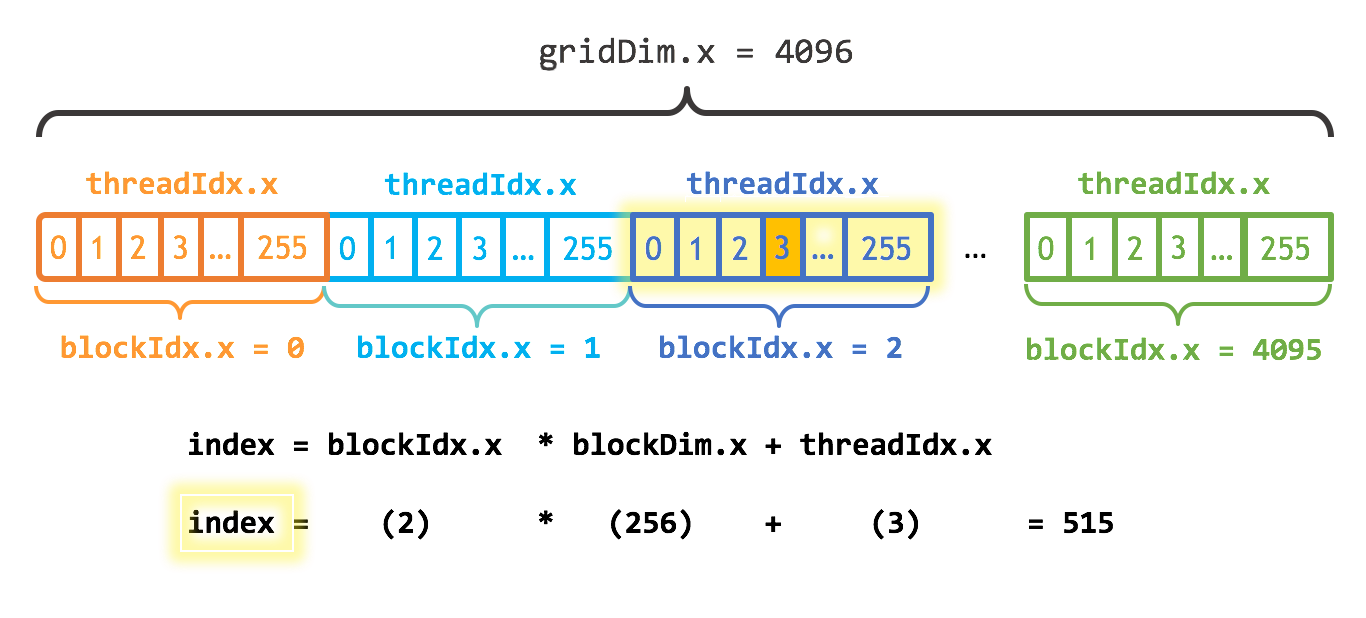

Grid、Block和Thread的示意图[2]

[2] Tim Besard [CUDA.jl](https://cuda.juliagpu.org/stable/tutorials/introduction/)

In [50]:
function convolution_kernel!(result, matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
    mask_size = size(mask)
    index_x = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    index_y = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    stride_x = gridDim().x * blockDim().x
    stride_y = gridDim().y * blockDim().y
    for i in index_x:stride_x:size(result)[1]
        for j in index_y:stride_y:size(result)[2]
            for idx in 1:mask_size[1], jdx in 1:mask_size[2]
                result[i, j] += matrix[i + idx - 1, j + jdx - 1] * mask[idx, jdx]
            end
        end
    end
    return nothing
end

convolution_kernel! (generic function with 1 method)

转移数据

In [51]:
cu_matrix = cu(img);
cu_mask = cu(mask);
result = CUDA.zeros(eltype(img), size(img) .- 2 .* (size(mask) .÷ 2));

准备运算

In [52]:
kernel = @cuda launch=false convolution_kernel!(result, cu_matrix, cu_mask)

CUDA.HostKernel{typeof(convolution_kernel!), Tuple{CuDeviceMatrix{RGB{Float32}, 1}, CuDeviceMatrix{RGB{Float32}, 1}, CuDeviceMatrix{Float32, 1}}}(convolution_kernel!, CuContext(0x0000000004bee680, instance 6bdeb78eca4bfa23), CuModule(Ptr{Nothing} @0x000000002fbea700, CuContext(0x0000000004bee680, instance 6bdeb78eca4bfa23)), CuFunction(Ptr{Nothing} @0x000000000b8c4c00, CuModule(Ptr{Nothing} @0x000000002fbea700, CuContext(0x0000000004bee680, instance 6bdeb78eca4bfa23))), CUDA.KernelState(Ptr{Nothing} @0x00007fd4c5800000))

查看推荐的thread数和block数

In [54]:
config = CUDA.launch_configuration(kernel.fun)

(blocks = 48, threads = 640)

启动运算

In [55]:
@show threads = floor.(Int, sqrt(config.threads / length(cu_matrix)) .* size(cu_matrix))
@show blocks = floor.(Int, sqrt(config.blocks / length(cu_matrix)) .* size(cu_matrix))

threads = floor.(Int, sqrt(config.threads / length(cu_matrix)) .* size(cu_matrix)) = (20, 31)
blocks = floor.(Int, sqrt(config.blocks / length(cu_matrix)) .* size(cu_matrix)) = (5, 8)


(5, 8)

In [56]:
kernel(result, cu_matrix, cu_mask; threads=threads, blocks=blocks)

取回结果

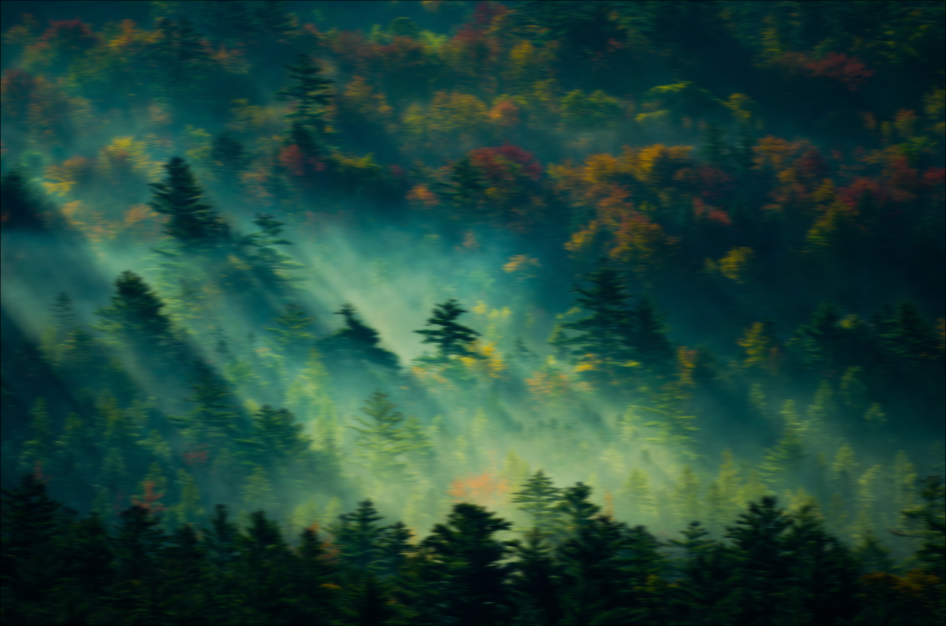

In [57]:
Array(result)

合并上面的过程

  175.916 ms (190 allocations: 213.79 MiB)


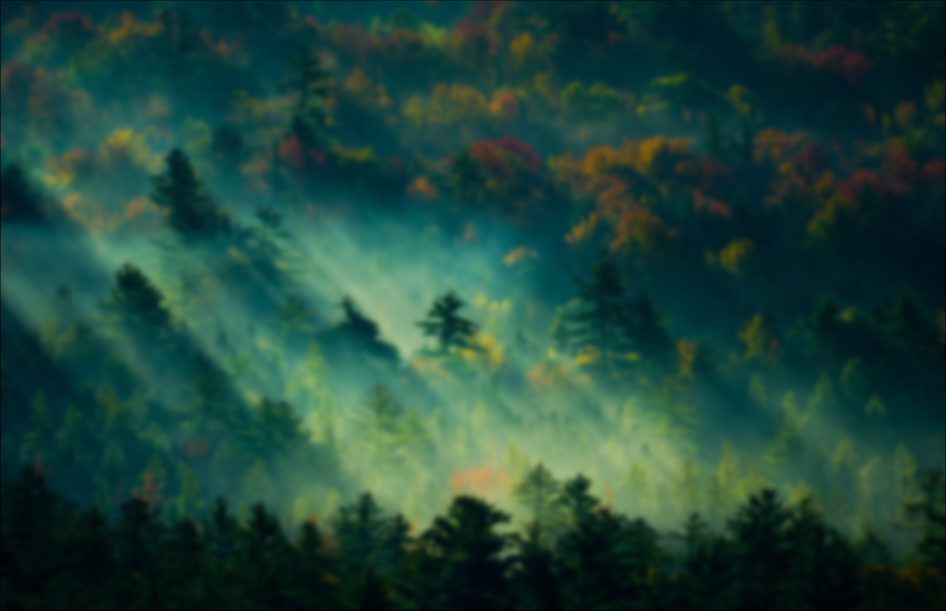

In [58]:
function ⊗(matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
    function convolution_kernel!(result, matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
        mask_size = size(mask)
        index_x = (blockIdx().x - 1) * blockDim().x + threadIdx().x
        index_y = (blockIdx().y - 1) * blockDim().y + threadIdx().y
        stride_x = gridDim().x * blockDim().x
        stride_y = gridDim().y * blockDim().y
        for i in index_x:stride_x:size(result)[1]
            for j in index_y:stride_y:size(result)[2]
                for idx in 1:mask_size[1], jdx in 1:mask_size[2]
                    result[i, j] += matrix[i + idx - 1, j + jdx - 1] * mask[idx, jdx]
                end
            end
        end
        return nothing
    end
    cu_matrix = cu(matrix);
    cu_mask = cu(mask);
    result = CUDA.zeros(eltype(matrix), size(matrix) .- 2 .* (size(mask) .÷ 2));
    kernel = @cuda launch=false convolution_kernel!(result, cu_matrix, cu_mask)
    threads = floor.(Int, sqrt(config.threads / length(cu_matrix)) .* size(cu_matrix))
    blocks = ceil.(Int, sqrt(config.blocks / length(cu_matrix)) .* size(cu_matrix))
    kernel(result, cu_matrix, cu_mask; threads=threads, blocks=blocks)
    return Array(result)
end
@btime $img ⊗ $mask ⊗ $(mask')

In [59]:
size(img)

(2501, 3840)

比并行的CPU更快了。

如何才能更快呢？

GPU运算中最耗时的部分并不是真正的计算，而是把数据传递到GPU上。因此两次卷积中间将数据传递回内存的过程是可以省略的，这能显著加快速度。

In [60]:
size(mask)

(1, 61)

  110.729 ms (181 allocations: 105.60 MiB)


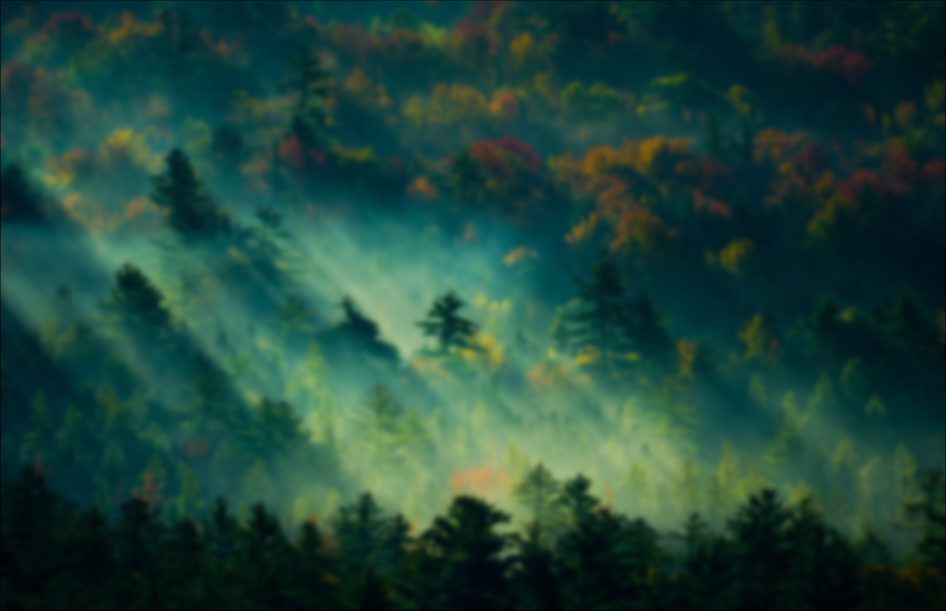

In [61]:
function ⊗(matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
    function convolution_kernel!(result, matrix::AbstractMatrix{T}, mask::AbstractMatrix) where {T}
        mask_size = size(mask)
        index_x = (blockIdx().x - 1) * blockDim().x + threadIdx().x
        index_y = (blockIdx().y - 1) * blockDim().y + threadIdx().y
        stride_x = gridDim().x * blockDim().x
        stride_y = gridDim().y * blockDim().y
        for i in index_x:stride_x:size(result)[1]
            for j in index_y:stride_y:size(result)[2]
                for idx in 1:mask_size[1], jdx in 1:mask_size[2]
                    result[i, j] += matrix[i + idx - 1, j + jdx - 1] * mask[idx, jdx]
                end
            end
        end
        return nothing
    end
    cu_matrix = cu(matrix);
    cu_mask = cu(mask);
    result = CUDA.zeros(eltype(matrix), size(matrix) .- 2 .* (size(mask) .÷ 2));
    kernel = @cuda launch=false convolution_kernel!(result, cu_matrix, cu_mask)
    threads = floor.(Int, sqrt(config.threads / length(cu_matrix)) .* size(cu_matrix))
    blocks = ceil.(Int, sqrt(config.blocks / length(cu_matrix)) .* size(cu_matrix))
    kernel(result, cu_matrix, cu_mask; threads=threads, blocks=blocks)
    return result
end
@btime Array($img ⊗ $mask ⊗ $(mask'))

几乎增加了到了原来的2x。实际上，真正用来运算的时间只有：

  24.779 ms (170 allocations: 8.19 KiB)


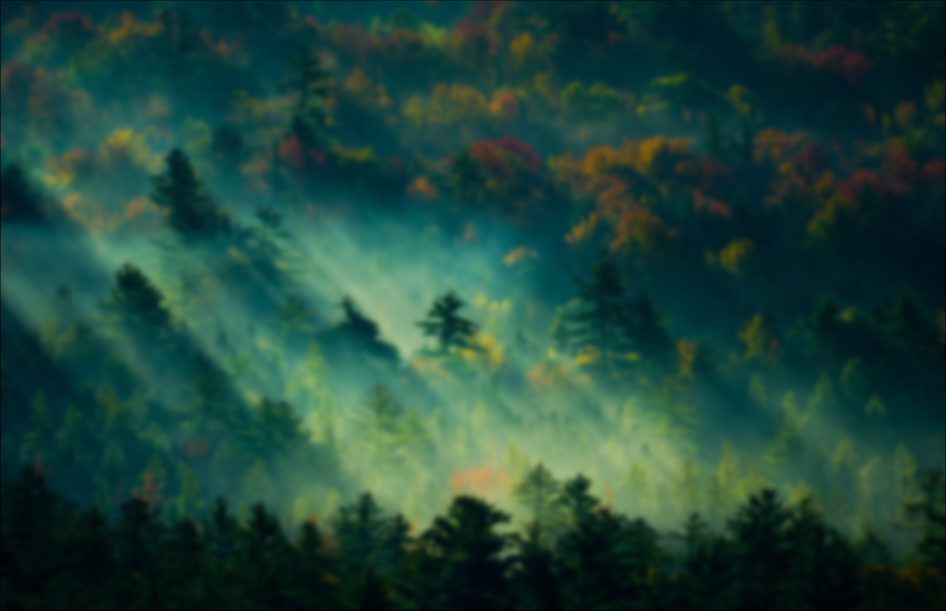

In [62]:
Array(@btime $(cu(img)) ⊗ $mask ⊗ $(mask'))

这是一张4K的图片，在60Hz的显示器上已经可以流畅运行了。

我们现在只需要大约20ms即可完成计算，相比于最开始200s，通过时间复杂度、并行、异构的优化提升到了原来的1000x。

补充：

* `sync_threads()`同步进程
* `@cuprintln`输出信息

In [63]:
function reduce_grid(op, a, b)
    elements = blockDim().x*2
    thread = threadIdx().x
    
    # serial reduction of values across blocks
    i = thread+elements
    while i <= length(a)
        a[thread] = op(a[thread], a[i])
        i += elements
    end

    # parallel reduction of values in a block
    d = 1
    while d < elements
        sync_threads()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && index+d <= length(a)
            @cuprintln "thread $thread: a[$index] + a[$(index+d)] = $(a[index]) + $(a[index+d]) = $(op(a[index], a[index+d]))"
            a[index] = op(a[index], a[index+d])
        end
        d *= 2
        thread == 1 && @cuprintln()
    end
    
    if thread == 1
        b[] = a[1]
    end
    
    return
end

a = CuArray(1:16)
b = CuArray([0])
@cuda threads=cld(length(a),2) reduce_grid(+, a, b)
CUDA.@allowscalar b[]

thread 1: a[1] + a[2] = 1 + 2 = 3
thread 2: a[3] + a[4] = 3 + 4 = 7
thread 3: a[5] + a[6] = 5 + 6 = 11
thread 4: a[7] + a[8] = 7 + 8 = 15
thread 5: a[9] + a[10] = 9 + 10 = 19
thread 6: a[11] + a[12] = 11 + 12 = 23
thread 7: a[13] + a[14] = 13 + 14 = 27
thread 8: a[15] + a[16] = 15 + 16 = 31

thread 1: a[1] + a[3] = 3 + 7 = 10
thread 2: a[5] + a[7] = 11 + 15 = 26
thread 3: a[9] + a[11] = 19 + 23 = 42
thread 4: a[13] + a[15] = 27 + 31 = 58

thread 1: a[1] + a[5] = 10 + 26 = 36
thread 2: a[9] + a[13] = 42 + 58 = 100

thread 1: a[1] + a[9] = 36 + 100 = 136



136